**Loading Dependences**

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.metrics import classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental.preprocessing import (Resizing, Rescaling, CenterCrop, 
                                                                RandomRotation, RandomZoom, RandomFlip)
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPool2D
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.data import AUTOTUNE
from tensorflow import expand_dims

**Loading Dataset**

In [2]:
# training data
train_data = image_dataset_from_directory('Data/PLD_3_Classes_256/Training')

# testing data
test_data = image_dataset_from_directory('Data/PLD_3_Classes_256/Testing')

# validation data
valid_data = image_dataset_from_directory('Data/PLD_3_Classes_256/Validation')

Found 3251 files belonging to 3 classes.
Found 405 files belonging to 3 classes.
Found 416 files belonging to 3 classes.


In [3]:
# getting train data image names
class_name = train_data.class_names

print(class_name)

['Early_Blight', 'Healthy', 'Late_Blight']


**Data Visualization**

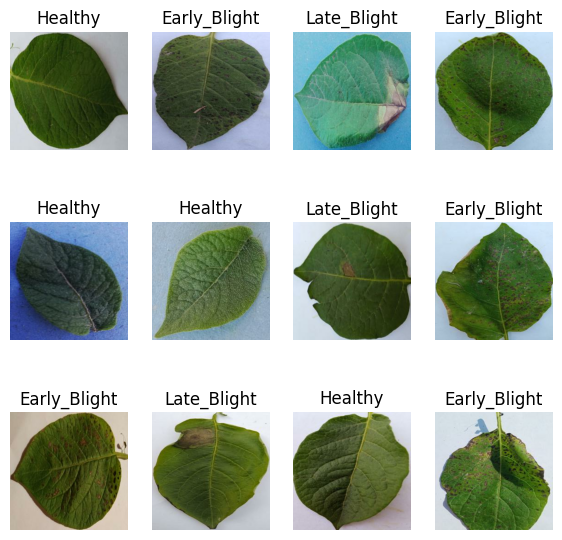

In [4]:
plt.figure(figsize=(7, 7))

# looping throught the images 
for image, label in train_data.take(1):
    for i in range(0, 12):
        plt.subplot(3, 4, i+1)
        plt.imshow(image[i].numpy().astype('uint32'))
        plt.title(class_name[label[i]])
        plt.axis('off')

**Shuffling and Prefetching of Image Data**

In [5]:
# Cache the elements in this train data.
train_data = train_data.cache().shuffle(1000).prefetch(AUTOTUNE)
# Cache the elements in this test data.
test_data = test_data.cache().shuffle(1000).prefetch(AUTOTUNE)
# Cache the elements in this valid data.
valid_data = valid_data.cache().shuffle(1000).prefetch(AUTOTUNE)

**Building Model with Data Augmentation**

In [7]:
# rescaling and resizing 
resize_scale = Sequential([
    # resizes images into 256.
    Resizing(256, 256),
    # rescales image values.
    Rescaling(1.0/255)
]) 

# data augmentation
#data_augmen = Sequential([
    # randomly flips images during training.
   # RandomFlip(mode='horizontal_and_vertical'),
    # randomly rotates images during training.
    #RandomRotation(factor=(-0.4, 0.4)), 
    # crops images.
    #CenterCrop(4, 2),
    # randomly zooms images during training.
    #RandomZoom(0.5, 0.3)
#])

In [8]:
# define input_shape
input_shape = [32, 256, 256, 3]
# building sequential neural network
def train_model():
    model = Sequential([
        resize_scale,
        #data_augmen,
        Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=input_shape),
        MaxPool2D(2, 2, padding='same'),
        Conv2D(64, (3, 3), padding='same', activation='relu'),
        MaxPool2D(2, 2, padding='same'),
        Dropout(0.2),
        Conv2D(128, (3, 3), padding='same', activation='relu'),
        MaxPool2D(2, 2, padding='same'),
        Dropout(0.2),
        Conv2D(256, (3, 3), padding='same', activation='relu'),
        MaxPool2D(2, 2, padding='same'),
        Dropout(0.2),
        Conv2D(512, (3, 3), padding='same', activation='relu'),
        MaxPool2D(2, 2, padding='same'),
        Dropout(0.2),
        Conv2D(64, (3, 3), padding='same', activation='relu'),
        MaxPool2D(2, 2, padding='same'),
        Dropout(0.2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(3, activation='softmax')
    ])
    return model

model = train_model()
# Builds the model
model.build(input_shape=input_shape)

In [9]:
# Prints a string summary of the network.
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 256, 256, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 128, 128, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 128, 128, 64)        9280      
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 64, 64, 64)         0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (32, 64, 64, 64)         

In [10]:
# Configures the model for training.
model.compile(
    # Optimizer that implements the RMSprop algorithm.
    optimizer=RMSprop(learning_rate=0.001), 
    # Computes the crossentropy loss between the labels and predictions.
    loss=SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [11]:
# Trains the model for a fixed number of epochs (iterations on a dataset).
history = model.fit(train_data, batch_size=64, epochs=20, validation_data=valid_data)

Epoch 1/20
102/102 [==============================] - ETA: 0s - loss: 1.1389 - accuracy: 0.3959 


KeyboardInterrupt



In [ ]:
def plot(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
    
plot(history, 'accuracy')
plot(history, 'loss')

In [ ]:
# Returns the loss value & metrics values for the model in test mode.
loss, acc = model.evaluate(test_data, batch_size=64)
print('Train Loss: {:.2f} and Train Accuracy: {:.2f}'.format(loss, acc))

In [ ]:
# Generates output predictions for the input samples.
y_pred = model.predict(test_data)
y_pred = np.argmax(y_pred, axis=1)

y_test = np.concatenate([y for y, x in test_data], axis=0)

In [ ]:
# Build a text report showing the main classification metrics.
#print(classification_report(y_test, y_pred, output_dict=True, target_names=class_name))

**Evaluating the Train Model**

In [ ]:
# evaluating in batch
def evaluate(model, img, class_name=['Early_Blight', 'Healthy', 'Late_Blight']):
    img_array = img_to_array(images[i].numpy())
    # Returns a tensor with a length 1 axis
    img_array = expand_dims(img_array, 0)
    
    prediction = model.predict(img_array)
    
    predicted_class = class_name[np.argmax(prediction[0])]
    confidence = round(100*(np.max(prediction[0])), 2)
    
    return predicted_class, confidence

In [ ]:
plt.figure(figsize=(13, 13))

# looping throught the images 
for images, labels in test_data.take(1):
    for i in range(0, 12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        predicted_class, confidence = evaluate(model, image[i].numpy())
        actual_class = class_name[labels[i]]
        
        plt.title('Actual: {},\n Predicted: {},\n Confidence: {}'.format(actual_class, predicted_class, confidence))
        plt.axis('off')